# VQE for ground state energy of H2 molecule using the UCCSD ansatz

Fermionic hamiltonian: Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.471896007281142 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.471896007281142 * ( +_3 -_3 )
+ 0.3378550774017582 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276483 * ( +_0 +_1 -_1 -_0 )
+ 0.3378550774017582 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276483 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211571 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211571 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211571 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211571 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211571 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211571 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211571 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211571 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276483 * ( +_1 +_0 -_0 -_1 )
+ 0.3492868613660083 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276483 * ( +_1 +_2 -_2 -_1 )
+ 0.3492868613660083 * ( +_1 +_3 -_3 -_1 )
+ 0.3378550774017582 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276483 * ( +_2 +_1 -_1 -_2 

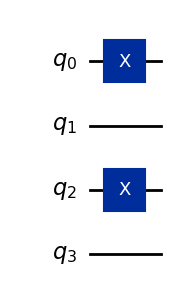

Singles-doubles CC (UCCSD) circuit:


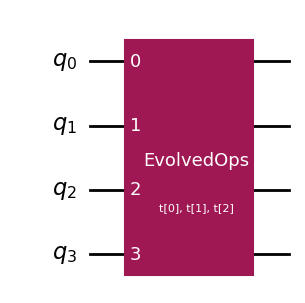


After first decomposition:


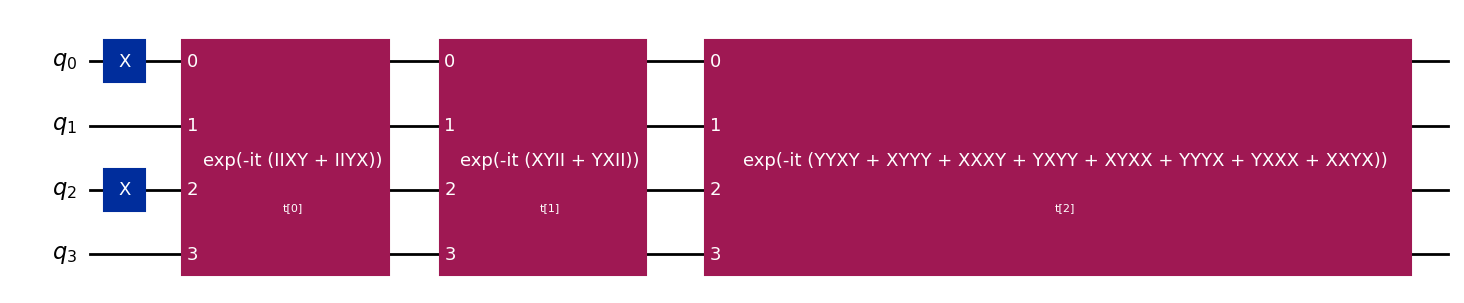


After second decomposition:


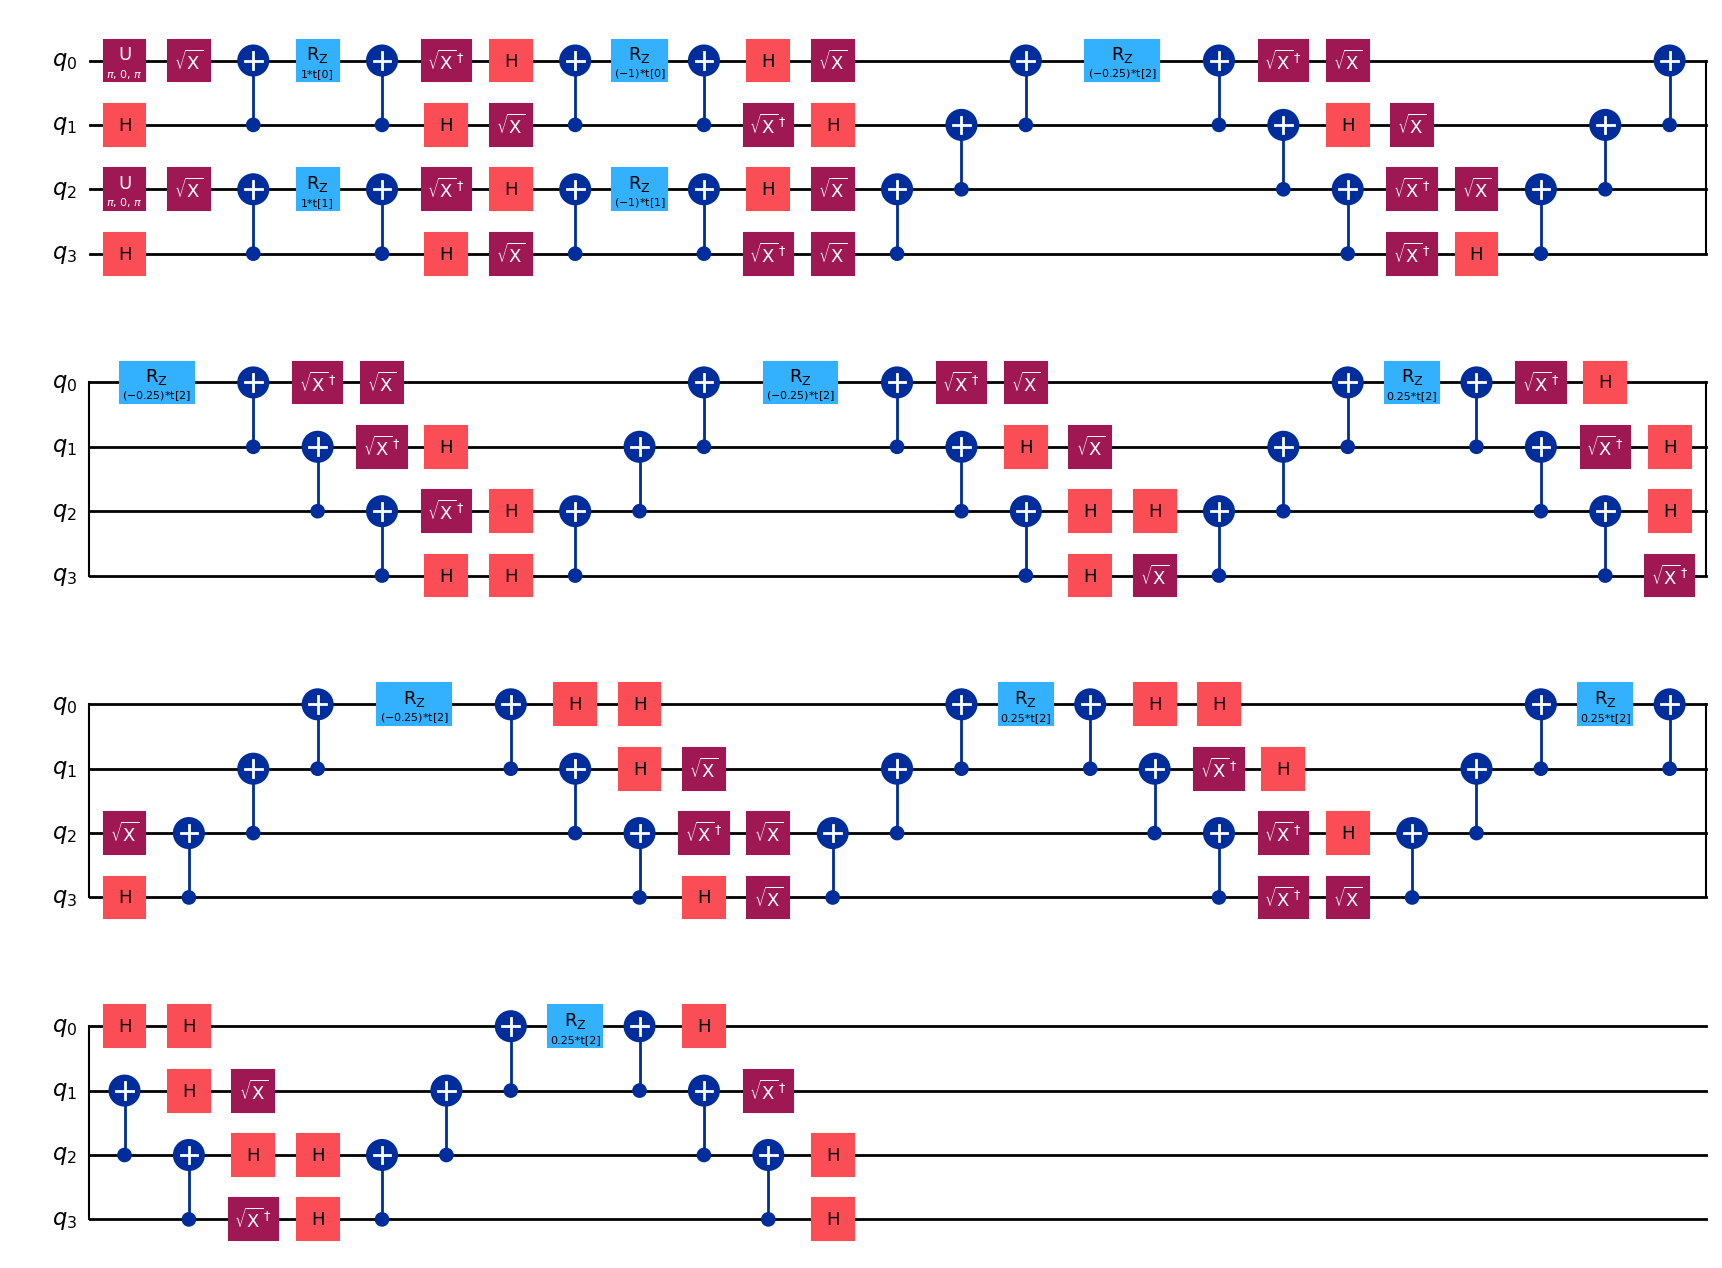


Number of parameters: 3


In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCC
from qiskit_nature.second_q.circuit.library import HartreeFock

# -----------------------------
# 1. Molecular problem (H2)
# -----------------------------
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    unit=DistanceUnit.ANGSTROM
)

problem = driver.run()

# The electronic Hamiltonian (FermionicOp) is stored within the problem
hamiltonian_fermionic = problem.hamiltonian.second_q_op()
print(f"Fermionic hamiltonian: {hamiltonian_fermionic}")

num_particles = problem.num_particles
print('Number of alpha- and beta-spin electrons:', num_particles)
num_spin_orbitals = problem.num_spin_orbitals
print('Number of spin orbitals:', num_spin_orbitals)


# -----------------------------
# 2. Qubit mapper
# -----------------------------
mapper = JordanWignerMapper()


# Initial state preparation
# Note: If we don't initialize the circuit, we are effectively staying in the vacuum state, i.e. no electrons are present.
# The UCC ansatz applied to the valuum state gives always the 0-vector. 
hf_state = HartreeFock(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper
)

print("\nHartree-Fock Circuit:")
display(hf_state.draw('mpl'))



# -----------------------------
# 3. Singles-doubles UCC ansatz (UCCSD)
# -----------------------------
uccs_ansatz = UCC(
    num_spatial_orbitals=num_spin_orbitals // 2,
    num_particles=num_particles,
    excitations="sd",        # singles only: 's'
    qubit_mapper=mapper,
    initial_state=hf_state
)

# -----------------------------
# 4. Draw the circuit
# -----------------------------
print("Singles-doubles CC (UCCSD) circuit:")

display(uccs_ansatz.draw('mpl'))
print("\nAfter first decomposition:")
display(uccs_ansatz.decompose().draw('mpl'))
print("\nAfter second decomposition:")
display(uccs_ansatz.decompose().decompose().draw('mpl'))

print("\nNumber of parameters:", uccs_ansatz.num_parameters)


---

## Solving for the ground state energy using VQE

In [2]:
from qiskit_algorithms.optimizers import COBYLA, SLSQP
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_algorithms.minimum_eigensolvers import VQE

# -----------------------------
# 5. Run VQE
# -----------------------------
# The Estimator calculates <psi|H|psi>
estimator = Estimator()

# COBYLA is a robust, gradient-free optimizer good for simple VQE tests
optimizer = COBYLA(maxiter=100)

# Initialize VQE
vqe = VQE(estimator, uccs_ansatz, optimizer)

# Map Fermionic Op to Qubit Op (Pauli Strings)
qubit_hamiltonian = mapper.map(hamiltonian_fermionic)  

# Execute the training
result = vqe.compute_minimum_eigenvalue(operator=qubit_hamiltonian)

# -----------------------------
# 6. Analyze Results
# -----------------------------
print(f"VQE Resulting Energy: {result.eigenvalue.real:.6f} Ha")
print(f"Optimal Parameters: {result.optimal_point}")

# Add nuclear repulsion energy to get Total Energy
total_energy = result.eigenvalue.real + problem.nuclear_repulsion_energy
print(f"Total Ground State Energy: {total_energy:.6f} Ha")

# Check if the output energy is within chemical accuracy range
# In computational chemistry, the "gold standard" for acceptable error is 1 kcal/mol, 
# which converts to approximately 0.0016 Hartree (Ha).
from qiskit_algorithms import NumPyMinimumEigensolver

# 1. Calculate the Exact Solution (Classically)
numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(operator=qubit_hamiltonian)
exact_energy = exact_result.eigenvalue.real + problem.nuclear_repulsion_energy

print(f"Exact Energy (FCI): {exact_energy:.6f} Ha")

# 2. Calculate Error
error = abs(total_energy - exact_energy)
print(f"Error:              {error:.6f} Ha")

# 3. Check Chemical Accuracy
chemical_accuracy = 0.0016
if error <= chemical_accuracy:
    print("✅ Success! The result is within chemical accuracy.")
else:
    print("❌ Result is outside chemical accuracy. Try increasing maxiter or changing optimizer.")

/Users/renata/Documents/PROJECTS/VENVs/qiskit-nature/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/renata/Documents/PROJECTS/VENVs/qiskit-nature/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


VQE Resulting Energy: -1.857275 Ha
Optimal Parameters: [-1.57074578 -1.57080578 -4.82417294]
Total Ground State Energy: -1.137306 Ha
Exact Energy (FCI): -1.137306 Ha
Error:              0.000000 Ha
✅ Success! The result is within chemical accuracy.


---

## Exploring the UCCS ansatz (single excitations only)

Singles-only CC (UCCS) circuit:


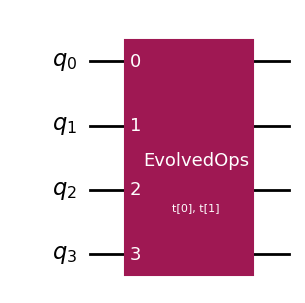


After first decomposition:


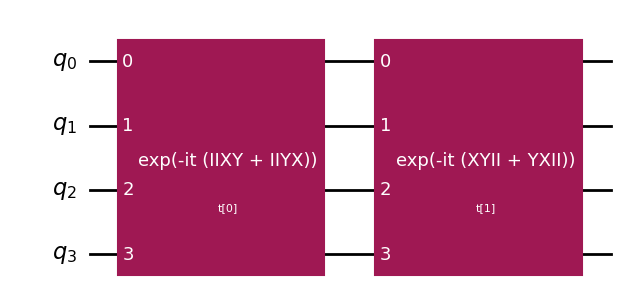


After second decomposition:


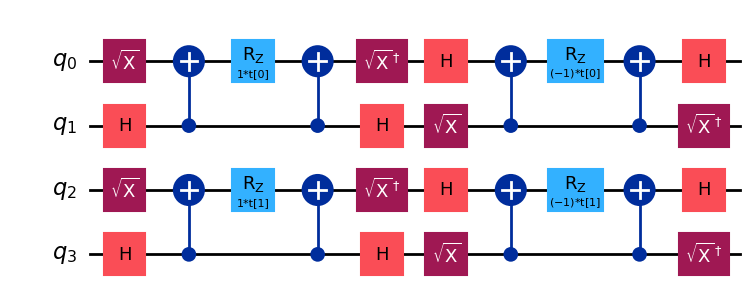


Number of parameters: 2


In [3]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCC


# -----------------------------
# 1. Molecular problem (H2)
# -----------------------------
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    unit=DistanceUnit.ANGSTROM
)

problem = driver.run()

# The electronic Hamiltonian (FermionicOp) is stored within the problem
hamiltonian_fermionic = problem.hamiltonian.second_q_op()
#print(f"Fermionic hamiltonian: {hamiltonian_fermionic}")

mapper = JordanWignerMapper()

num_particles = problem.num_particles
num_spin_orbitals = problem.num_spin_orbitals

# -----------------------------
# Singles-only UCC ansatz (UCCS)
# -----------------------------
uccs_ansatz = UCC(
    num_spatial_orbitals=num_spin_orbitals // 2,
    num_particles=num_particles,
    excitations="s",       
    qubit_mapper=mapper
)

# -----------------------------
# Draw the circuit
# -----------------------------
print("Singles-only CC (UCCS) circuit:")

display(uccs_ansatz.draw('mpl'))
print("\nAfter first decomposition:")
display(uccs_ansatz.decompose().draw('mpl'))
print("\nAfter second decomposition:")
display(uccs_ansatz.decompose().decompose().draw('mpl'))

print("\nNumber of parameters:", uccs_ansatz.num_parameters)

---

## Exploring the UCCD ansatz (double excitations only)

Doubles-only CC (UCCD) circuit:


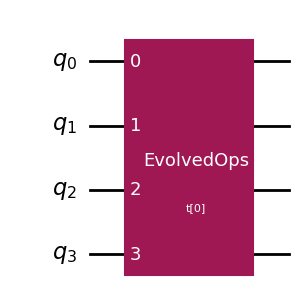


After first decomposition:


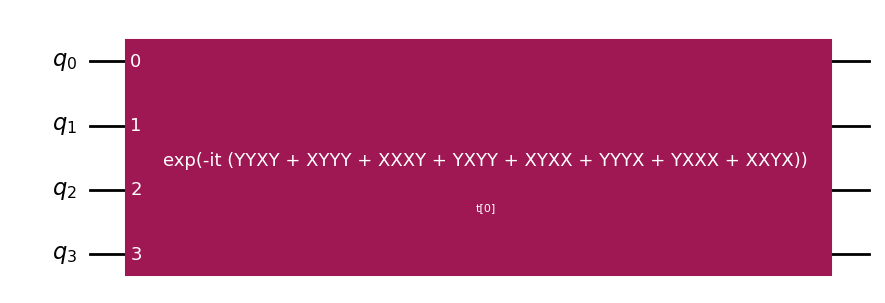


After second decomposition:


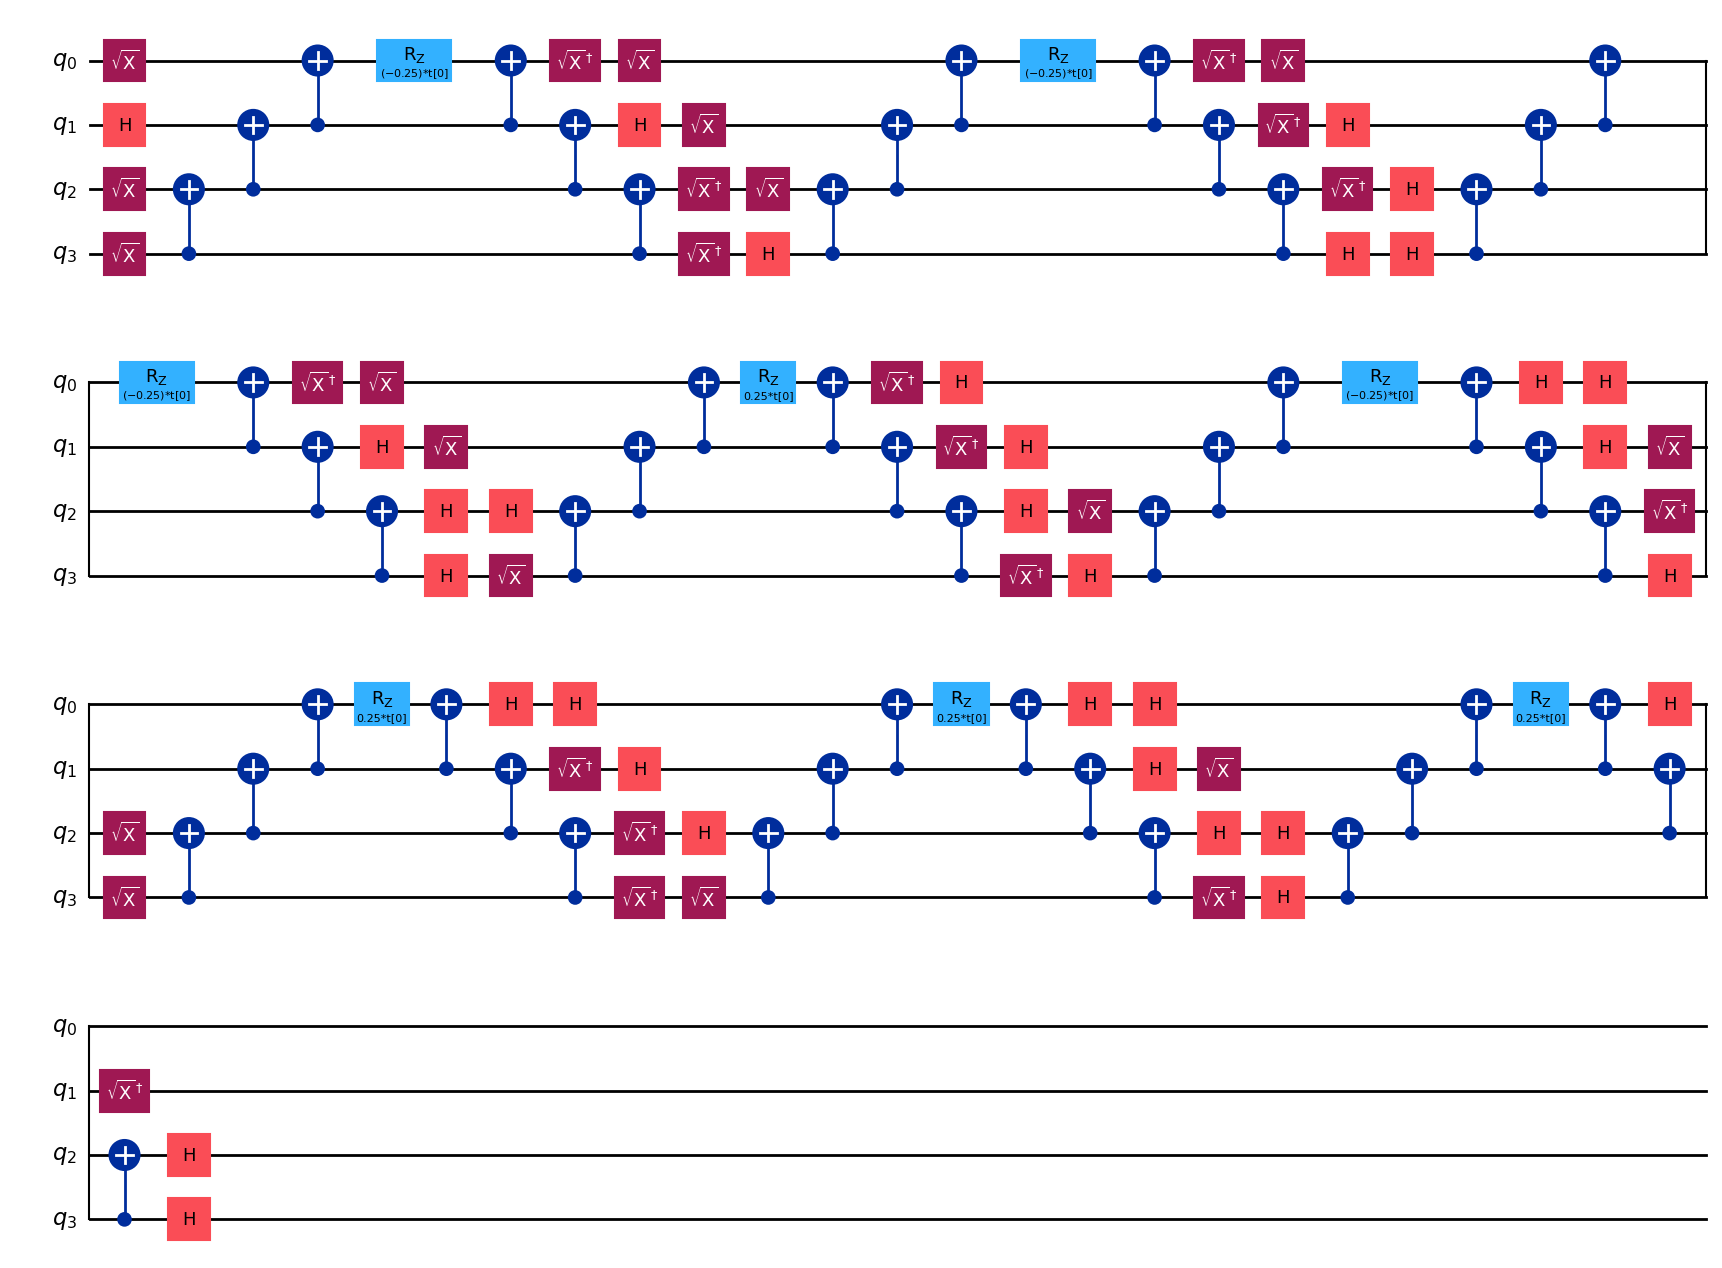


Number of parameters: 1


In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCC


# -----------------------------
# 1. Molecular problem (H2)
# -----------------------------
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    unit=DistanceUnit.ANGSTROM
)

problem = driver.run()

# The electronic Hamiltonian (FermionicOp) is stored within the problem
hamiltonian_fermionic = problem.hamiltonian.second_q_op()
#print(f"Fermionic hamiltonian: {hamiltonian_fermionic}")

mapper = JordanWignerMapper()

num_particles = problem.num_particles
num_spin_orbitals = problem.num_spin_orbitals

# -----------------------------
# Doubles-only UCC ansatz (UCCD)
# -----------------------------
uccs_ansatz = UCC(
    num_spatial_orbitals=num_spin_orbitals // 2,
    num_particles=num_particles,
    excitations="d",       
    qubit_mapper=mapper
)

# -----------------------------
# Draw the circuit
# -----------------------------
print("Doubles-only CC (UCCD) circuit:")

display(uccs_ansatz.draw('mpl'))
print("\nAfter first decomposition:")
display(uccs_ansatz.decompose().draw('mpl'))
print("\nAfter second decomposition:")
display(uccs_ansatz.decompose().decompose().draw('mpl'))

print("\nNumber of parameters:", uccs_ansatz.num_parameters)

In [13]:
%pip list | grep qiskit

qiskit                  2.2.3
qiskit-aer              0.17.2
qiskit-algorithms       0.4.0
qiskit-ibm-runtime      0.44.0
qiskit-nature           0.7.2
Note: you may need to restart the kernel to use updated packages.


<div style="background-color:#f0f0f0; padding:10px; border-radius:5px;">
This code is a part of Quantum AI Biomedical Research Lab project 
    
`Estimating molecular ground and excited state energies on quantum computers'
    
© Copyright Renata Wong, 2026.

This code is licensed under the CC BY-NC 4.0 License. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at https://creativecommons.org/licenses/by-nc/4.0/deed.en.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.
</div>

<div style="background-color:#f0f0f0; padding:10px; border-radius:5px;">
This work was supported by the National Science and Technology Council (Taiwan) grant No. NSTC 114-2112-M-182-002-MY3 and Chang Gung Memorial Hospital grant No. BMRPL94.

This work comes with an accompanying paper titled 'Quantum circuit compilation for fermionic excitations using the Jordan-Wigner mapping'.
</div>